In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.dates import DateFormatter
import datetime as dt
from datetime import timedelta

In [2]:
# Reading in the dataframes
custom_df1 = 'C:/Users/Peter/py_projects/solar_stats/custom_df.p'
custom_df2 = 'C:/Users/Peter/py_projects/solar_stats/custom_sep.p'
df = pd.read_pickle(custom_df1)
sp = pd.read_pickle(custom_df2)

In [3]:
# df data
all_regions = df.srs_active_region_no.dropna(how='any').astype(float)
sp_regions = sp.region.dropna(how='any')
print(sp_regions[pd.to_numeric(sp_regions, errors='coerce').isnull()])

sp_regions.replace('9212,13,18','9212', regex=True, inplace=True)
sp_regions.replace('Filament', np.nan, regex=True, inplace=True)

# Dropping the 'filament' nan
sp_regions = sp_regions.dropna(how='any').astype(float)

# Looking at which entries in all_regions match any from sp_regions
bools = all_regions.isin(sp_regions)

# keeping entries of boolean True only
bools = bools[bools]

# Getting the True indices and using to create a new filtered df 
idx = bools.index.tolist()
df2 = df.loc[idx]

23      Filament
26    9212,13,18
Name: region, dtype: object


In [4]:
# Properties to look at (limiting to max and min dates from the SEP data)
fls = df2[['flare_start_time', 'flare_peak_time', 'cme_speed', 'srs_active_region_no', 'goes_flux']]
fls = fls.dropna(how='any')
fls = fls[ (fls['flare_start_time'] >= dt.datetime(1997, 11, 4)) & (fls['flare_start_time'] <= dt.datetime(2017, 9, 6)) ] 
fls = fls.reset_index(drop=True)

spf = sp[['proton_flux', 'flare_max', 'region']]
spf = spf.dropna(how='any')
spf = spf.reset_index(drop=True)

In [5]:
# found this online to find the value in the 'items' column closest to the 'pivot' value
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [6]:
# Finding all the nearest values for the flare_peak_time to the SEP flare_max 
both = (np.zeros(len(spf.flare_max))).astype('O')
for i in range(len(both)):
    both[i] = nearest(fls.flare_peak_time, spf.flare_max.iloc[i])

In [7]:
# Now getting the indices for these nearest values
idxb = np.zeros(len(both))
for j in range(len(idxb)):
    b = fls['flare_peak_time'].index[fls.flare_peak_time==both[j]].tolist()
    idxb[j] = b[0]
    
# Now to keep only the corresponding data for these entries
fls2 = fls.loc[idxb]    

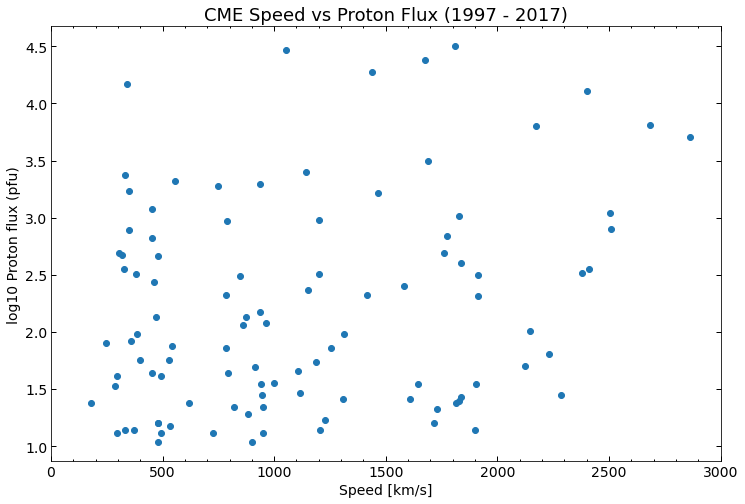

In [8]:
fig, ax = plt.subplots(figsize=[12, 8], facecolor='white')

sct = ax.scatter(fls2.cme_speed, np.log10(spf.proton_flux))
ax.set_title('CME Speed vs Proton Flux (1997 - 2017)', fontsize=18)
ax.set_xlabel('Speed [km/s]', fontsize=14)
ax.set_ylabel('log10 Proton flux (pfu)', fontsize=14)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_xlim([0,3000])

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax.tick_params(axis='both', length=2, top=True, right=True, direction='in', which='minor', width=1)

#plt.savefig('speed_pfu.png', dpi=300, bbox_inches="tight", pad_inches=1)
plt.show()

## Let's try to correlate entries from both datasets better

## Struggling to figure this out. What I've done below is find the max flare time entries in both datasets that EXACTLY match. Gives a better correlation, but only 53 datapoints

In [9]:
fls_times = fls.flare_peak_time
spf_times = spf.flare_max

a = spf_times.isin(fls_times)
a=a[a]

b = fls_times.isin(spf_times)
b=b[b]

# Getting the True indices and using to create a new filtered dfs
ia = a.index.tolist()
ib = b.index.tolist()
adf = spf.loc[ia]
bdf = fls.loc[ib]

In [10]:
print(len(adf))
print(len(bdf))

53
57


In [11]:
# Finding all the nearest values for the flare_peak_time to the SEP flare_max 
t1 = (np.zeros(len(adf.flare_max))).astype('O')
for i in range(len(t1)):
    t1[i] = nearest(bdf.flare_peak_time, adf.flare_max.iloc[i])
    
# Now getting the indices for these nearest values
t2 = np.zeros(len(t1))
for j in range(len(t2)):
    t3 = bdf['flare_peak_time'].index[bdf.flare_peak_time==t1[j]].tolist()
    t2[j] = t3[0]
    
# Now to keep only the corresponding data for these entries
idk = bdf.loc[t2]    

In [12]:
"""
from astropy.modeling import models, fitting

# define a model for a line
model = models.Linear1D()

# initialize a linear fitter (least squares)
fitter = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()
"""

from scipy.stats import linregress

# Stats
fit1_stats = linregress(idk.cme_speed, np.log10(adf.proton_flux)) 
fit2_stats = linregress(np.log10(idk.goes_flux), np.log10(adf.proton_flux)) 

print(fit1_stats,'\n')
print(fit2_stats)


LinregressResult(slope=0.0007900445439336871, intercept=1.0710059777230767, rvalue=0.49124727485878256, pvalue=0.00018764139604928072, stderr=0.000196152813480183) 

LinregressResult(slope=0.9382602423987284, intercept=6.0261733368137005, rvalue=0.5709548508068198, pvalue=8.032236627305268e-06, stderr=0.1889164642821409)


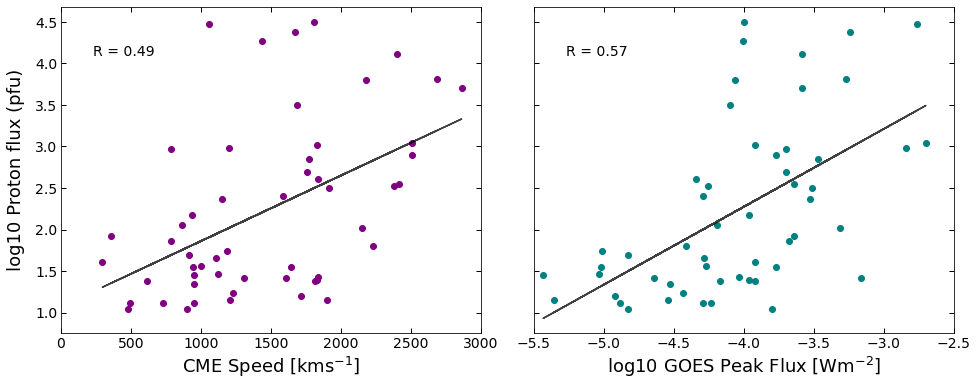

In [14]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey='row', facecolor='white')
fig1.subplots_adjust(wspace=0.125)

sct1 = ax1.scatter(idk.cme_speed, np.log10(adf.proton_flux), c='purple')
#ax1.set_title('CME Speed vs Proton Flux (1997 - 2017)', fontsize=18)
ax1.set_xlabel('CME Speed [kms$^{-1}$]', fontsize=18)
ax1.set_ylabel('log10 Proton flux (pfu)', fontsize=18, labelpad=10)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_xlim([0,3000])
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax1.tick_params(axis='both', length=2, top=False, right=True, bottom=False, direction='in', which='minor', width=1)

#fit
ax1.text(0.15, 0.85, 'R = 0.49', fontsize=14, horizontalalignment='center', transform=ax1.transAxes)
ax1.plot(idk.cme_speed, fit1_stats.intercept + fit1_stats.slope*idk.cme_speed, 'k-', alpha=0.75)
#fit1 = fitter(line_init, idk.cme_speed, np.log10(adf.proton_flux))
#ax1.plot(idk.cme_speed, fitted1(idk.cme_speed), 'k--')

#==================================================================================================================

sct2 = ax2.scatter(np.log10(idk.goes_flux), np.log10(adf.proton_flux), c='teal')
#ax2.set_title('GOES Flux vs Proton Flux (1997 - 2017)', fontsize=18)
ax2.set_xlabel('log10 GOES Peak Flux [Wm$^{-2}$]', fontsize=18)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlim([-5.5,-2.5])
ax2.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax2.tick_params(axis='both', length=2, top=True, right=True, direction='in', which='minor', width=1)

#fit
ax2.text(0.15, 0.85, 'R = 0.57', fontsize=14, horizontalalignment='center', transform=ax2.transAxes)
ax2.plot(np.log10(idk.goes_flux), fit2_stats.intercept + fit2_stats.slope*np.log10(idk.goes_flux), 'k-', alpha=0.75)
#fit2 = fitter(line_init, np.log10(idk.goes_flux), np.log10(adf.proton_flux))
#ax2.plot(np.log10(idk.goes_flux), fitted2(np.log10(idk.goes_flux)), 'k', linestyle='--')

#plt.savefig('spe_plots.png', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [253]:
idk

,flare_start_time,flare_peak_time,cme_speed,srs_active_region_no,goes_flux
0.0,1997-11-04 05:52:00,1997-11-04 05:58:00,785.0,8100,0.000210
12.0,1998-05-02 13:31:00,1998-05-02 13:42:00,938.0,8210,0.000110
33.0,1999-06-04 06:52:00,1999-06-04 07:03:00,2230.0,8552,0.000039
34.0,2000-02-17 20:17:00,2000-02-17 20:35:00,728.0,8872,0.000013
35.0,2000-04-04 15:12:00,2000-04-04 15:41:00,1188.0,8933,0.000010
43.0,2000-06-06 14:58:00,2000-06-06 15:25:00,358.0,9026,0.000230
50.0,2000-06-10 16:40:00,2000-06-10 17:02:00,1108.0,9026,0.000052
58.0,2000-07-14 10:03:00,2000-07-14 10:24:00,1674.0,9077,0.000570
61.0,2000-07-22 11:17:00,2000-07-22 11:34:00,1230.0,9085,0.000037
75.0,2000-11-24 04:55:00,2000-11-24 05:02:00,788.0,9236,0.000200
